In [2]:
import os
import json
import base64
import numpy as np
import pandas as pd
import geopandas as gpd
from typing import Optional
from pyiceberg.expressions import And, GreaterThanOrEqual, LessThanOrEqual
from pyiceberg.catalog import load_catalog

In [3]:
bspo_gplc_ove = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/BSOP_MSA/bspo_google_comparison/bsop_gplc_ove.geojson')
print(bspo_gplc_ove['is_true_match'].notna().sum() / len(bspo_gplc_ove))
bspo_gplc_ove['is_true_match'].value_counts()

0.6449190330908238


is_true_match
1    2339
0     409
Name: count, dtype: int64

In [4]:
bspo_gplc_sf = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/BSOP_MSA/bspo_google_comparison/bsop_gplc_sf.geojson')
print(bspo_gplc_sf['is_true_match'].notna().sum() / len(bspo_gplc_sf))
bspo_gplc_sf['is_true_match'].value_counts()

0.6254400375498709


is_true_match
1    2443
0     222
Name: count, dtype: int64

In [5]:
bspo_gplc_fsq = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/BSOP_MSA/bspo_google_comparison/bspo_gplc_fsq.geojson')
print(bspo_gplc_fsq['is_true_match'].notna().sum() / len(bspo_gplc_fsq))
bspo_gplc_fsq['is_true_match'].value_counts()

0.6444496597042948


is_true_match
1    2242
0     504
Name: count, dtype: int64

In [6]:
bspo_gplc_osm = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/BSOP_MSA/bspo_google_comparison/bsop_gplc_osm.geojson')
print(bspo_gplc_osm['is_true_match'].notna().sum() / len(bspo_gplc_osm))
bspo_gplc_osm['is_true_match'].value_counts()

0.4179770007040601


is_true_match
1    1292
0     489
Name: count, dtype: int64

In [7]:
def summarize_category_match_rate(
    df: pd.DataFrame,
    cat_col: str = "primary_cat",
    true_col: str = "is_true_match",
    true_values=(True, "1"),
    compare_col="ove_count",
    ref_col="google_count",
    cg_m_col: str = "ove_google_m",
    cat_per: str = "cat_per",
) -> pd.DataFrame:
    """
    Summarize Google POI counts, matched Overture counts,
    and match rate by category.
    """

    # ---- matched subset ----
    df_true = df[df[true_col].isin(true_values)]

    # ---- Google category counts (denominator) ----
    g_cat = (
        df[cat_col]
        .value_counts()
        .rename(ref_col)
        .to_frame()
    )
    g_cat[cat_per] = g_cat[ref_col] / len(df)

    # ---- Overture matched category counts (numerator) ----
    o_cat = (
        df_true[cat_col]
        .value_counts()
        .rename(compare_col)
        .to_frame()
    )

    # ---- merge & compute rate ----
    df_out = (
        o_cat
        .merge(g_cat, left_index=True, right_index=True, how="inner")
        .reset_index()
        .rename(columns={"index": cat_col})
        .sort_values(ref_col, ascending=False)
    )

    df_out[cg_m_col] = df_out[compare_col] / df_out[ref_col]

    return df_out

In [9]:
summarize_by_bspo_gplc_ove = summarize_category_match_rate(bspo_gplc_ove, compare_col="ove_count", ref_col="google_count", cg_m_col = "ove_google_m")
summarize_by_bspo_gplc_sf = summarize_category_match_rate(bspo_gplc_sf, compare_col="sf_count", ref_col="google_count", cg_m_col = "sf_google_m")
summarize_by_bspo_gplc_fsq = summarize_category_match_rate(bspo_gplc_fsq, compare_col="fsq_count", ref_col="google_count", cg_m_col = "fsq_google_m")
summarize_by_bspo_gplc_osm = summarize_category_match_rate(bspo_gplc_osm, compare_col="osm_count", ref_col="google_count", cg_m_col = "osm_google_m")

In [10]:
from functools import reduce

# List your dataframes (Fixing the OSM reference)
dfs = [
    summarize_by_bspo_gplc_ove[['primary_cat', 'google_count', 'ove_count', 'ove_google_m']],
    summarize_by_bspo_gplc_sf[['primary_cat', 'sf_count', 'sf_google_m']],
    summarize_by_bspo_gplc_fsq[['primary_cat', 'fsq_count', 'fsq_google_m']],
    summarize_by_bspo_gplc_osm[['primary_cat', 'osm_count', 'osm_google_m']] # Assumed name fix
]

# Merge them all on 'primary_cat'
summarize_df_merge = reduce(lambda left, right: pd.merge(left, right, on='primary_cat', how='inner'), dfs)

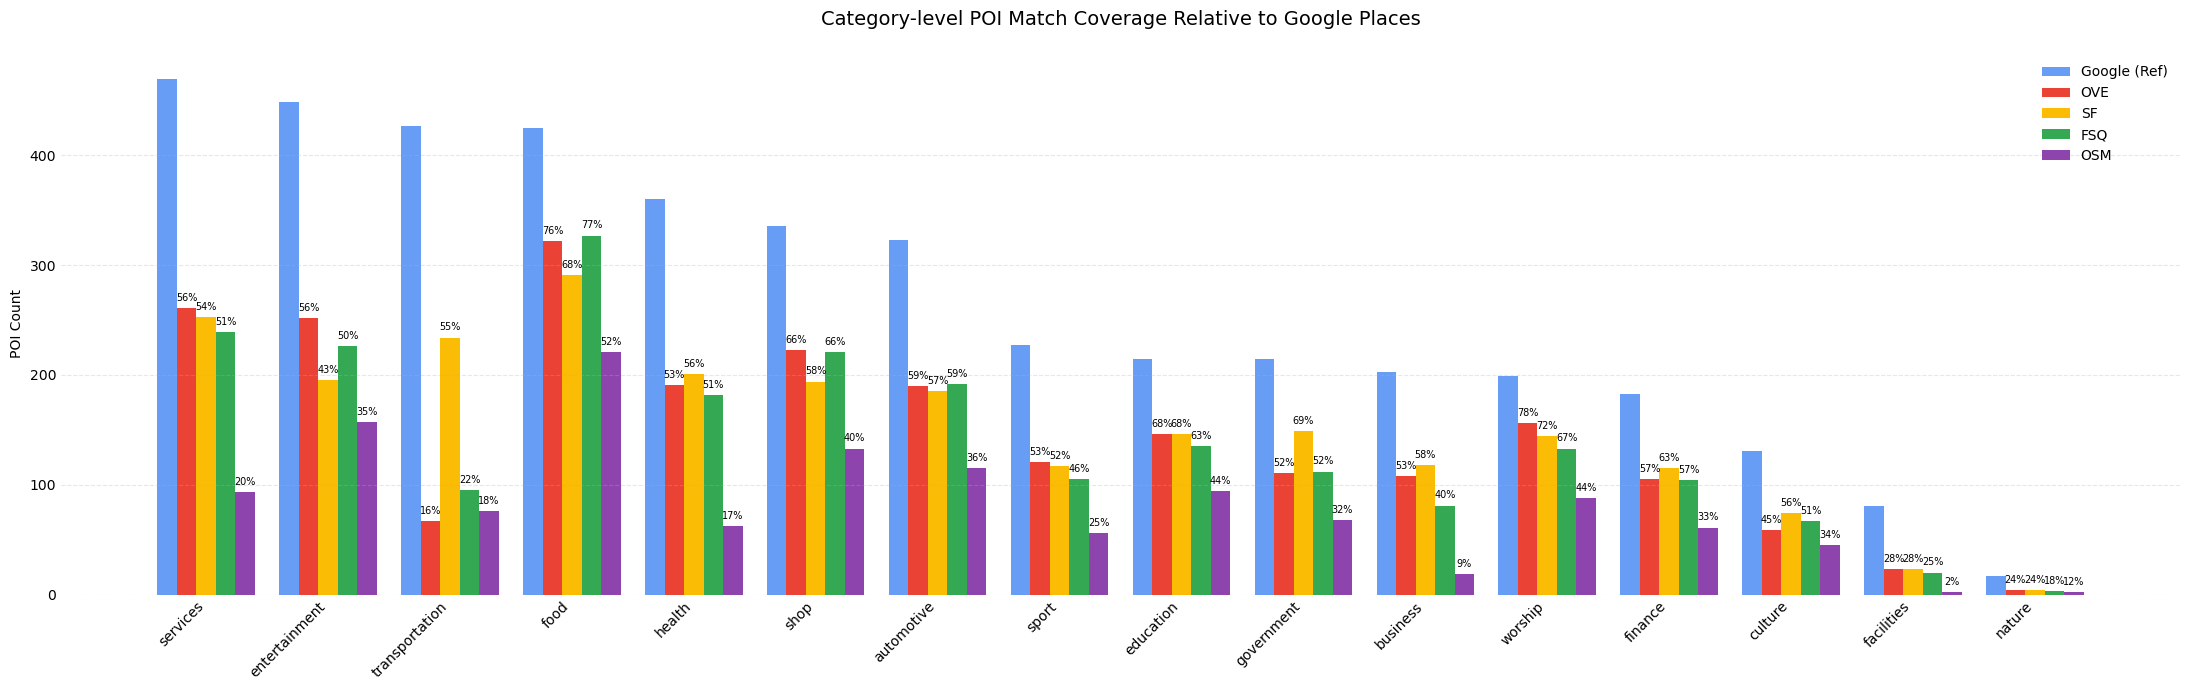

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multi_category_coverage(
    df,
    cat_col="primary_cat",
    # 定义需要对比的源及其对应的列名后缀
    sources=["ove", "sf", "fsq", "osm"],
    ref_col="google_count",
    figsize=(22, 7),
    title="Category-level POI Match Coverage Relative to Google Places"
):
    df = df.reset_index(drop=True)
    n_categories = len(df)
    n_sources = len(sources) + 1  # 加上 Google 参考栏
    
    # 调整宽度：总宽度为 0.8，平分给各个 source
    total_width = 0.8
    single_width = total_width / n_sources
    x = np.arange(n_categories)

    # 创建画布，frameon=False 去掉背景框
    fig, ax = plt.subplots(figsize=figsize, frameon=True)

    # 1. 绘制 Google 参考栏 (通常放在第一位)
    ax.bar(
        x - total_width/2 + single_width/2, 
        df[ref_col], 
        single_width, 
        label="Google (Ref)", 
        color="#4285F4", # Google Blue
        alpha=0.8
    )

    # 2. 循环绘制其他 Sources
    colors = ["#EA4335", "#FBBC05", "#34A853", "#8E44AD"] # 红, 黄, 绿, 紫
    for i, src in enumerate(sources):
        offset = (i + 1) * single_width
        pos = x - total_width/2 + offset + single_width/2
        
        count_col = f"{src}_count"
        ratio_col = f"{src}_google_m"
        
        bars = ax.bar(pos, df[count_col], single_width, label=src.upper(), color=colors[i])

        # 在每个柱子上方标注百分比
        for j, bar in enumerate(bars):
            val = df.loc[j, ratio_col] * 100
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + (df[ref_col].max() * 0.01), # 微调标注高度
                f"{val:.0f}%",
                ha="center", va="bottom", fontsize=7, rotation=0
            )

    # ---- 移除图框 (Spines) ----
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)
    
    # 移除刻度线，保留标签
    ax.tick_params(axis='both', which='both', length=0)

    # 设置样式
    ax.set_xticks(x)
    ax.set_xticklabels(df[cat_col], rotation=45, ha="right")
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_ylabel("POI Count")
    
    # 添加水平参考线（可选，增加可读性）
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    
    ax.legend(frameon=False, loc="upper right")
    plt.tight_layout()
    plt.show()

# 调用函数
plot_multi_category_coverage(summarize_df_merge)

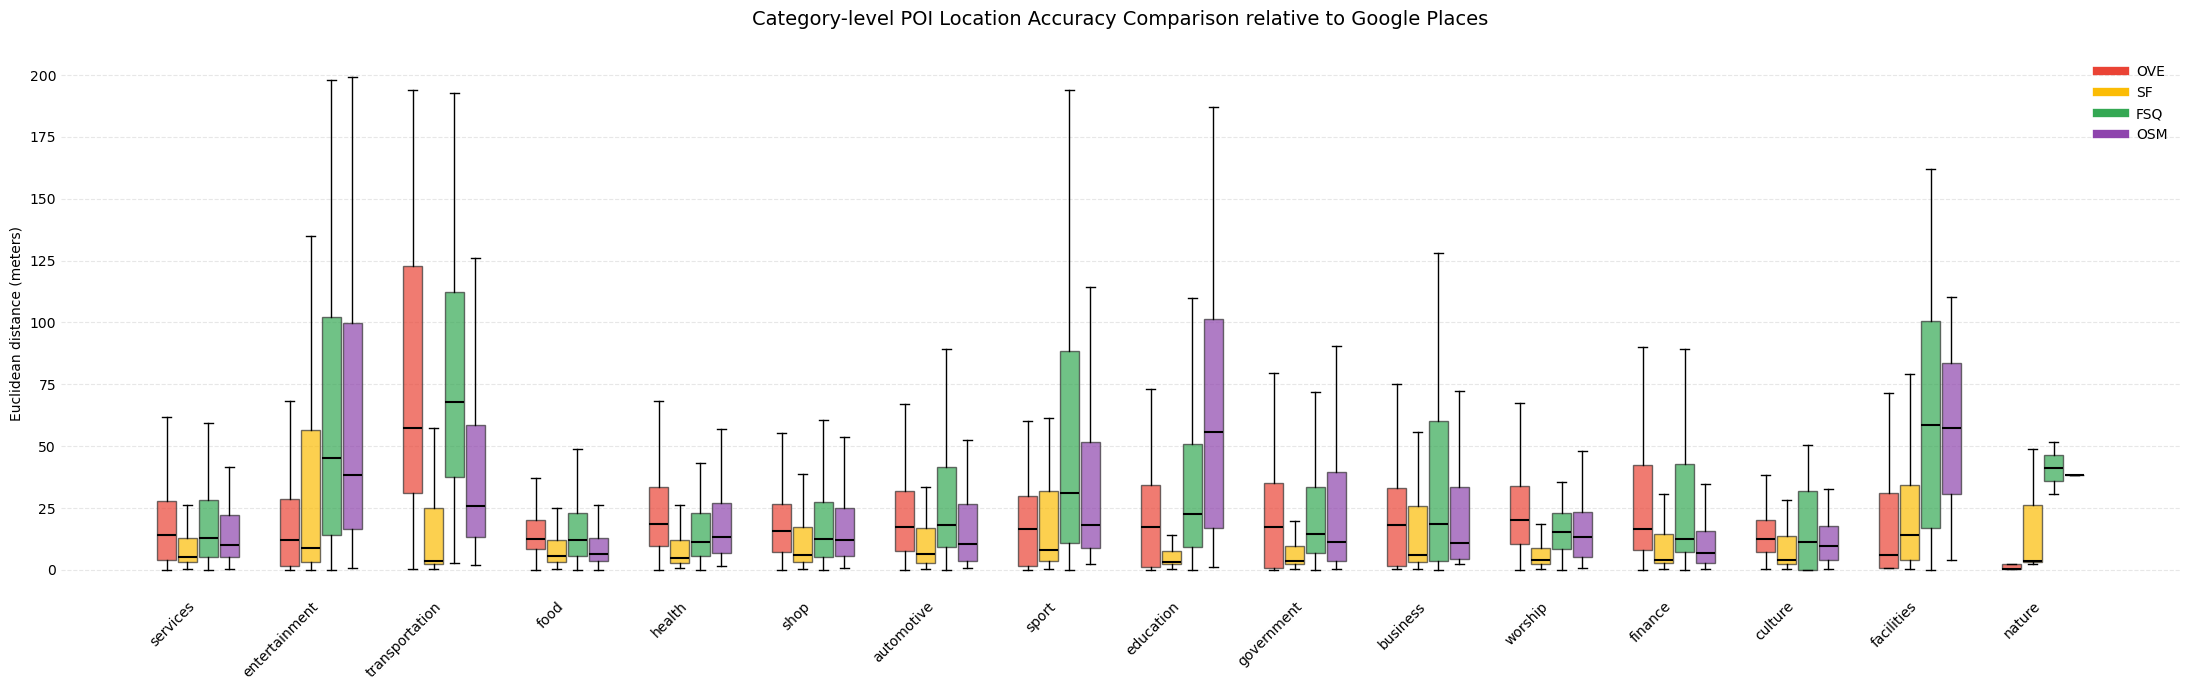

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 准备数据设置
sources = ['ove', 'sf', 'fsq', 'osm']
labels = ['OVE', 'SF', 'FSQ', 'OSM']
colors = ["#EA4335", "#FBBC05", "#34A853", "#8E44AD"] # 红, 黄, 绿, 紫
MAX_DIST = 200

# 假设你的四个 DataFrame 存储在一个字典里方便循环
dfs = {
    'ove': bspo_gplc_ove,
    'sf': bspo_gplc_sf,
    'fsq': bspo_gplc_fsq,
    'osm': bspo_gplc_osm
}

# 2. 确定类别顺序（以 google_count 排序的 summarize_df_merge 为准）
# 确保只包含在所有数据源中都存在的类别
cats_clean = summarize_df_merge.sort_values('google_count', ascending=False)['primary_cat'].tolist()

# 3. 图表布局参数
n_cats = len(cats_clean)
n_sources = len(sources)
width = 0.15  # 单个箱体的宽度
spacing = 0.2 # 类别内部箱体的间距系数

fig, ax = plt.subplots(figsize=(22, 7), frameon=True) 

# 存储 legend 的句柄
legend_handles = []

# 4. 循环绘制每个 source 的箱线图
for i, src_key in enumerate(sources):
    current_df = dfs[src_key]
    
    # 过滤数据：True Match 且 距离小于 MAX_DIST
    mask = (current_df['is_true_match'].isin([True, "1"])) & (current_df['location_distance'] <= MAX_DIST)
    filtered_df = current_df[mask]
    
    # 按 cats_clean 顺序提取数据
    data_to_plot = []
    for c in cats_clean:
        vals = filtered_df[filtered_df['primary_cat'] == c]['location_distance'].dropna().values
        data_to_plot.append(vals if len(vals) > 0 else [np.nan]) # 防止空数据报错

    # 计算该 source 的箱体位置偏移
    # 比如：-0.3, -0.1, 0.1, 0.3 均匀分布在整数刻度两侧
    pos = np.arange(n_cats) + (i - (n_sources-1)/2) * (width + 0.02)
    
    bp = ax.boxplot(
        data_to_plot,
        positions=pos,
        widths=width,
        patch_artist=True,
        showfliers=False,
        manage_ticks=False # 关键：防止 boxplot 自动修改坐标轴刻度
    )

    # 美化箱体颜色
    for box in bp['boxes']:
        box.set_facecolor(colors[i])
        box.set_alpha(0.7)
        box.set_edgecolor('#333333')
    
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(1.5)

    # 收集 legend
    legend_handles.append(plt.Line2D([0], [0], color=colors[i], lw=6, label=labels[i]))

# 5. 清洁外观定制 (Clean Look)
# 移除所有图框边线
for spine in ax.spines.values():
    spine.set_visible(False)

# 移除刻度线，保留文字
ax.tick_params(axis='both', which='both', length=0)

# 设置坐标轴标签
ax.set_xticks(np.arange(n_cats))
ax.set_xticklabels(cats_clean, rotation=45, ha='right')
ax.set_ylabel("Euclidean distance (meters)")
ax.set_title("Category-level POI Location Accuracy Comparison relative to Google Places", fontsize=14, pad=20)

# 添加水平网格线，增强可读性
ax.yaxis.grid(True, linestyle='--', alpha=0.3)

ax.legend(handles=legend_handles, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

In [13]:
def add_distance_bins_to_point(
    gdf,
    ref,
    n_bins=20,
    src_crs="EPSG:4326",
    proj_crs="EPSG:3857",
    dist_col="dist_to_point",
    bin_col="dist_bin"
):

    gdf = gdf.copy()

    # reference point
    pt = ref
    pt_gdf = gpd.GeoDataFrame(geometry=[pt], crs=src_crs)

    # project
    gdf_proj = gdf.to_crs(proj_crs)
    pt_proj = pt_gdf.to_crs(proj_crs)

    # distance (meters)
    gdf[dist_col] = gdf_proj.geometry.distance(pt_proj.geometry.iloc[0]) 

    # bins
    dmin, dmax = gdf[dist_col].min(), gdf[dist_col].max()
    bins = np.linspace(dmin, dmax, n_bins + 1)

    gdf[bin_col] = pd.cut(gdf[dist_col],bins=bins,include_lowest=True)

    return gdf

In [15]:
from shapely.geometry import Point
center_p = Point(-122.62572036324582, 47.562212843385126) # Harborside Fountain Park

bspo_gplc_ove = add_distance_bins_to_point(bspo_gplc_ove,center_p,n_bins=20,src_crs="EPSG:4326",proj_crs="EPSG:3857",dist_col="dist_to_point",bin_col="dist_bin")
bspo_gplc_sf = add_distance_bins_to_point(bspo_gplc_sf,center_p,n_bins=20,src_crs="EPSG:4326",proj_crs="EPSG:3857",dist_col="dist_to_point",bin_col="dist_bin")
bspo_gplc_fsq = add_distance_bins_to_point(bspo_gplc_fsq,center_p,n_bins=20,src_crs="EPSG:4326",proj_crs="EPSG:3857",dist_col="dist_to_point",bin_col="dist_bin")
bspo_gplc_osm = add_distance_bins_to_point(bspo_gplc_osm,center_p,n_bins=20,src_crs="EPSG:4326",proj_crs="EPSG:3857",dist_col="dist_to_point",bin_col="dist_bin")

In [16]:
def summarize_match_miss_by_dist_bin(
    gdf: pd.DataFrame,
    cat_col: str = "primary_cat",
    dist_bin_col: str = "dist_bin",
    true_col: str = "is_true_match",
    match_value= '1',
    name_score_col: str = "name_score", 
    n_mistake_col: str = "n_mistake",
    n_miss_col: str = "n_miss",
    n_nonmatch_col: str = "n_nonmatch",
    n_match_col: str = "n_match",
    nonmtach_c_col: str = "non_match_c",
    match_c_col: str = "match_c",
    non_match_density_col: str = "nonmatch_den",
    match_density_col: str = "match_den",
    total_density_col: str = "total_den", 
    median_name_score_col: str = "median_name_score", 
    ring_area_col: str = "ring_area",
    bin_id_col: str = "bin_id",
    area_unit: str = "m2",   # "m2" or "km2"
) -> pd.DataFrame:

    df = gdf.copy()

    # group stats
    df_out = (
        df.groupby([cat_col, dist_bin_col], observed=True)
          .apply(lambda x: pd.Series({
              "n_total": len(x),
              n_match_col: x[true_col].eq(match_value).sum(),
              n_nonmatch_col:  (~x[true_col].eq(match_value)).sum(),  # NaN -> miss
              n_mistake_col: x[true_col].eq("0").sum(), # n_mistake_match: true_col == "0"
              n_miss_col: x[true_col].isna().sum(), # n_first_miss: true_col 是 NaN
              median_name_score_col: x[name_score_col].median(),
          }))
          .reset_index()
    )

    # proportions within each bin
    df_out[match_c_col] = df_out[n_match_col] / (df_out["n_total"])
    df_out[nonmtach_c_col]  = df_out[n_nonmatch_col]  / (df_out["n_total"])

    # bin order within each category
    df_out[bin_id_col] = df_out.groupby(cat_col, observed=True).cumcount() + 1

    # ring area
    area = df_out[dist_bin_col].apply(lambda x: np.pi * (x.right**2 - x.left**2)).astype(float)
    if area_unit == "km2":
        area = area / 1e6
    df_out[ring_area_col] = area

    # densities (per m² or per km²)
    df_out[non_match_density_col]  = df_out[n_nonmatch_col]  / (df_out[ring_area_col])
    df_out[match_density_col] = df_out[n_match_col] / (df_out[ring_area_col])
    df_out[total_density_col] = df_out["n_total"] / (df_out[ring_area_col])
    
    return df_out

In [17]:
ove_all_bins = summarize_match_miss_by_dist_bin(
    bspo_gplc_ove,
    cat_col = "primary_cat",
    dist_bin_col = "dist_bin",
    true_col = "is_true_match",
    match_value = '1',
    n_mistake_col = "n_mistake_ove",
    n_miss_col = "n_miss_ove",
    n_nonmatch_col = "n_nonmatch_ove",
    n_match_col = "n_match_ove",
    nonmtach_c_col = "non_match_c_ove",
    match_c_col = "match_c_ove",
    non_match_density_col = "nonmatch_den_ove",
    match_density_col = "match_den_ove",
    total_density_col = "total_den_google", 
    ring_area_col = "ring_area",
    bin_id_col = "bin_id",
    area_unit = "km2",   # "m2" or "km2"
)

sf_all_bins = summarize_match_miss_by_dist_bin(
    bspo_gplc_sf,
    cat_col = "primary_cat",
    dist_bin_col = "dist_bin",
    true_col = "is_true_match",
    match_value = '1',
    n_mistake_col = "n_mistake_sf",
    n_miss_col = "n_miss_sf",
    n_nonmatch_col = "n_nonmatch_sf",
    n_match_col = "n_match_sf",
    nonmtach_c_col = "non_match_c_sf",
    match_c_col = "match_c_sf",
    non_match_density_col = "nonmatch_den_sf",
    match_density_col = "match_den_sf",
    total_density_col = "total_den_google", 
    ring_area_col = "ring_area",
    bin_id_col = "bin_id",
    area_unit = "km2",   # "m2" or "km2"
)

fsq_all_bins = summarize_match_miss_by_dist_bin(
    bspo_gplc_fsq,
    cat_col = "primary_cat",
    dist_bin_col = "dist_bin",
    true_col = "is_true_match",
    match_value = '1',
    n_mistake_col = "n_mistake_fsq",
    n_miss_col = "n_miss_fsq",
    n_nonmatch_col = "n_nonmatch_fsq",
    n_match_col = "n_match_fsq",
    nonmtach_c_col = "non_match_c_fsq",
    match_c_col = "match_c_fsq",
    non_match_density_col = "nonmatch_den_fsq",
    match_density_col = "match_den_fsq",
    total_density_col = "total_den_google", 
    ring_area_col = "ring_area",
    bin_id_col = "bin_id",
    area_unit = "km2",   # "m2" or "km2"
)

osm_all_bins = summarize_match_miss_by_dist_bin(
    bspo_gplc_osm,
    cat_col = "primary_cat",
    dist_bin_col = "dist_bin",
    true_col = "is_true_match",
    match_value = '1',
    n_mistake_col = "n_mistake_osm",
    n_miss_col = "n_miss_osm",
    n_nonmatch_col = "n_nonmatch_osm",
    n_match_col = "n_match_osm",
    nonmtach_c_col = "non_match_c_osm",
    match_c_col = "match_c_osm",
    non_match_density_col = "nonmatch_den_osm",
    match_density_col = "match_den_osm",
    total_density_col = "total_den_google", 
    ring_area_col = "ring_area",
    bin_id_col = "bin_id",
    area_unit = "km2",   # "m2" or "km2"
)

In [18]:
import pandas as pd

# 准备需要拼接的列表
dfs_to_concat = [
    ove_all_bins[['primary_cat','dist_bin','bin_id','ring_area','n_total','n_match_ove','n_nonmatch_ove','n_mistake_ove','n_miss_ove','match_c_ove','non_match_c_ove','nonmatch_den_ove','match_den_ove','total_den_google']],
    sf_all_bins.drop(columns=['primary_cat','dist_bin','n_total','median_name_score','bin_id','ring_area','total_den_google']),
    fsq_all_bins.drop(columns=['primary_cat','dist_bin','n_total','median_name_score','bin_id','ring_area','total_den_google']),
    osm_all_bins.drop(columns=['primary_cat','dist_bin','n_total','median_name_score','bin_id','ring_area','total_den_google'])
]

# 执行横向拼接 (axis=1)
all_bins = pd.concat(dfs_to_concat, axis=1)

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_missmate_by_dist(
    df,
    dens_cols=("total_den_google", "match_den_ove", "match_den_sf", "match_den_fsq", "match_den_osm"),
    colors=None,
    markers=True,
    primary_cat_col="primary_cat",
    xlabel="Distance bin (1 = closest to CBD)",
    ylabel="Density (per km²)",
    title="Category-level POI Match Density Comparison relative to Google Places",
    n_cols=4,
    xtick_fontsize=8,
):
    # 1. 扩展颜色配置，适应 5 个因素
    if colors is None:
        colors = {
            "total_den_google": "#4285F4",  # Google Blue
            "match_den_ove":    "#EA4335",  # Overture Red
            "match_den_sf":     "#FBBC05",  # SafeGraph Yellow
            "match_den_fsq":    "#34A853",  # Foursquare Green
            "match_den_osm":    "#8E44AD",  # OSM Purple
        }

    # 自定义图例显示的文字
    display_labels = {
        "total_den_google": "Google (Total)",
        "match_den_ove":    "Overture",
        "match_den_sf":     "SafeGraph",
        "match_den_fsq":    "Foursquare",
        "match_den_osm":    "OSM"
    }

    cats = sorted(df[primary_cat_col].unique())
    n_cats = len(cats)
    n_rows = int(np.ceil(n_cats / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols + 1, 3 * n_rows + 1), # 稍微增加高度给顶部留白
        squeeze=False,
        sharex=True,
        sharey=True
    )

    for ax, cat in zip(axes.flat, cats):
        df_cat = df[df[primary_cat_col] == cat].sort_values("bin_id")
        x = df_cat["bin_id"]

        for col in dens_cols:
            if col in df_cat.columns:
                ax.plot(
                    x,
                    df_cat[col],
                    label=display_labels.get(col, col),
                    color=colors.get(col, "#333333"),
                    marker="o" if markers else None,
                    markersize=4,
                    linewidth=1.5,
                    alpha=0.8,
                )

        ax.set_title(cat, fontsize=14, pad=20)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticks(x)
        ax.tick_params(axis="x", labelsize=xtick_fontsize)
        
        # 移除图框逻辑 (可选，为了保持极简风)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)

    # 隐藏多余的子图
    for ax in axes.flat[n_cats:]:
        ax.axis("off")

    # 2. 核心调整：Legend 与 Title 分层布局
    # 首先设置大标题，固定在最上方
    fig.suptitle(title, fontsize=14, y=0.98, va="top")

    # 获取图例句柄
    handles, labels = axes.flat[0].get_legend_handles_labels()

    # 放置图例：bbox_to_anchor 的第二个参数 (0.93) 决定了它的垂直位置
    # 它应该位于 suptitle (0.98) 之下，子图区域 (0.90) 之上
    fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.93), 
        frameon=False,
        ncol=len(dens_cols),
        fontsize=10
    )

    # 3. 调整子图区域，为顶部的 Title 和 Legend 留出空间 (rect=[left, bottom, right, top])
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()

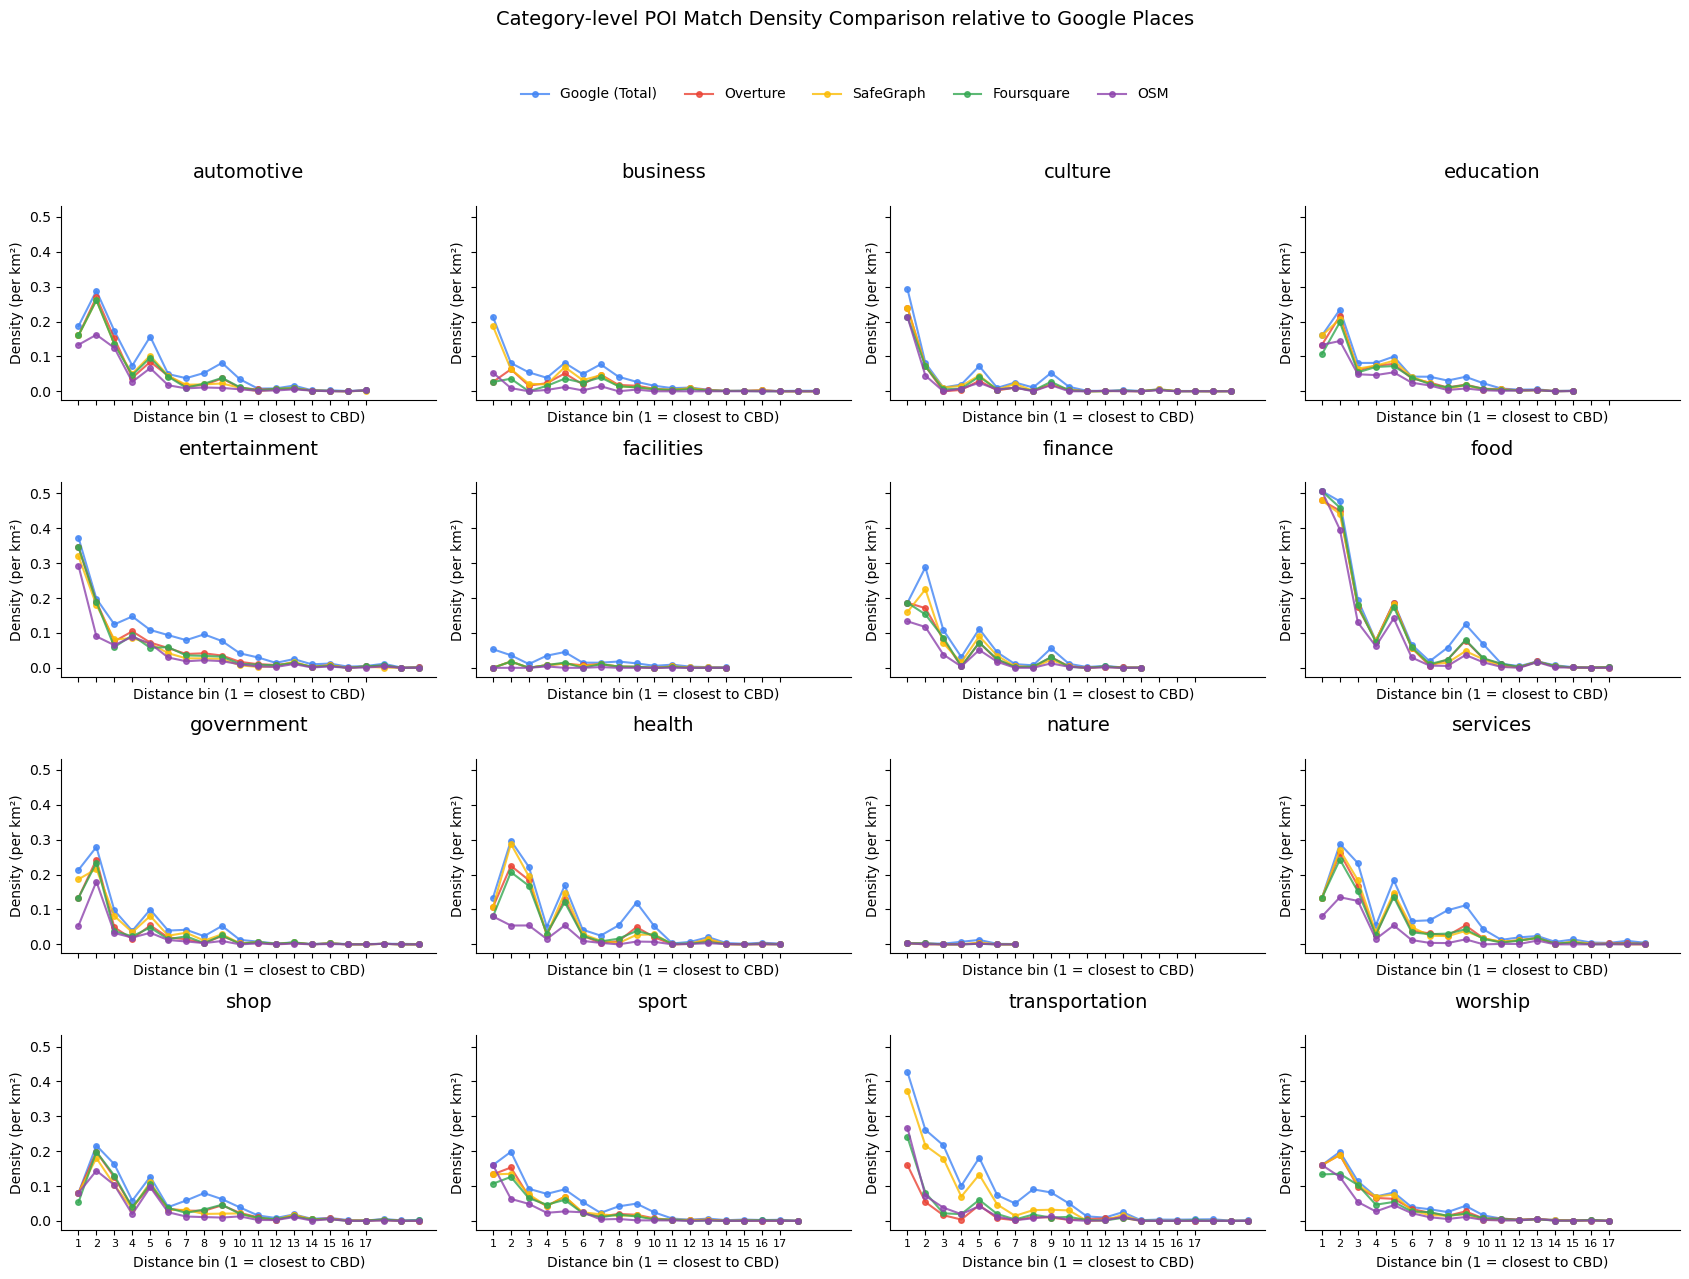

In [20]:
plot_missmate_by_dist(
    all_bins,
    dens_cols=("total_den_google","match_den_ove","match_den_sf","match_den_fsq","match_den_osm"),
    title="Category-level POI Match Density Comparison relative to Google Places"
)

/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/ipykernel_55270/1683549495.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')
/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/ipykernel_55270/1683549495.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.92])


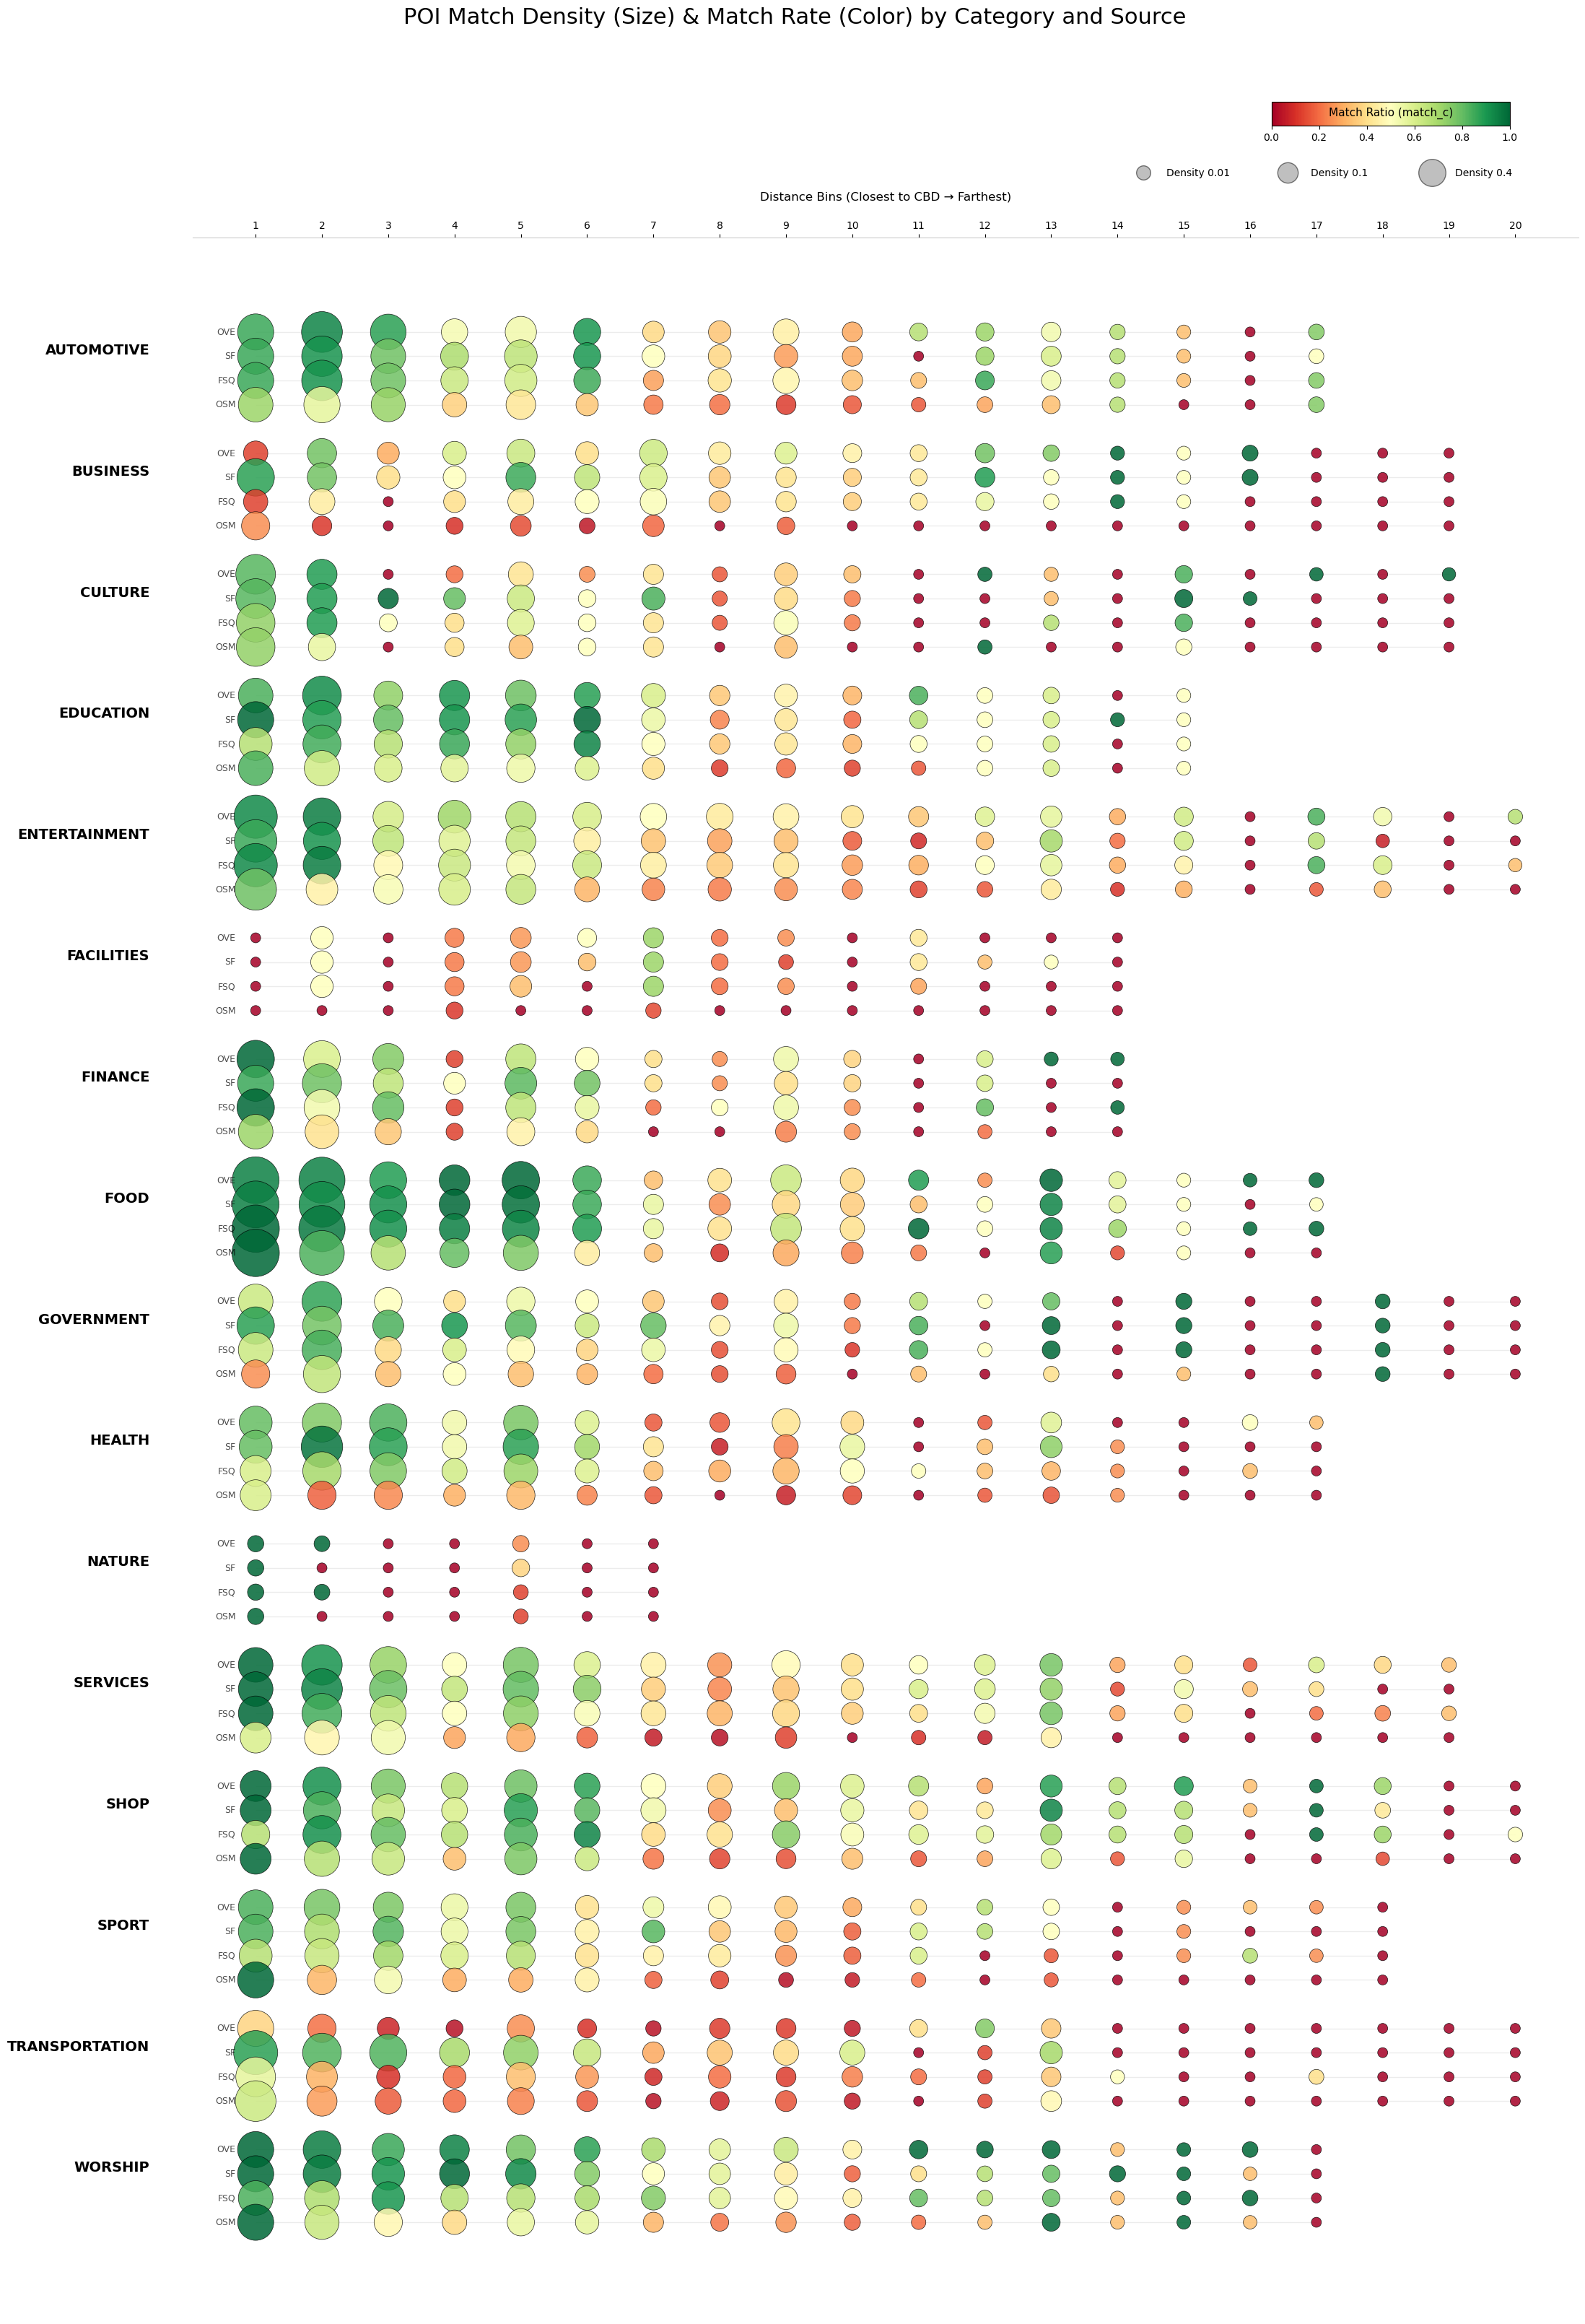

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_bubble_distancebins(
    df,
    primary_cat_col="primary_cat",
    bin_col="bin_id",
    sources=["ove", "sf", "fsq", "osm"],
):
    # 基础准备
    cats = sorted(df[primary_cat_col].unique(), reverse=True) 
    n_cats = len(cats)
    
    # 【优化】动态计算高度：根据类别数量自动调整 figsize，避免固定 38 导致的过度留白
    dynamic_height = n_cats * 1.8 + 4
    fig, ax = plt.subplots(figsize=(22, dynamic_height), facecolor='white')

    cmap = cm.get_cmap('RdYlGn') 
    
    for i, cat in enumerate(cats):
        base_y = i * 4  
        df_cat = df[df[primary_cat_col] == cat].sort_values(bin_col)
        
        ax.text(-0.6, base_y - 0.6, cat.upper(), ha='right', va='center', fontweight='bold', fontsize=14)

        for j, src in enumerate(sources):
            line_y = base_y - (j * 0.8) 
            x = df_cat[bin_col]
            den_val = df_cat[f"match_den_{src}"]
            c_val = df_cat[f"match_c_{src}"]
            
            ax.hlines(line_y, x.min(), x.max(), colors='gray', alpha=0.15, linewidth=1, zorder=1)
            ax.text(x.min() - 0.3, line_y, src.upper(), ha='right', va='center', fontsize=9, alpha=0.7)

            bubble_sizes = np.sqrt(den_val) * 3000 + 100 
            
            scatter = ax.scatter(
                x, [line_y] * len(x),
                s=bubble_sizes,
                c=c_val,
                cmap=cmap,
                vmin=0, vmax=1,
                edgecolors='black',
                linewidths=0.5,
                alpha=0.85,
                zorder=2
            )

    # 【优化】X 轴移到上方
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    
    ax.get_yaxis().set_visible(False)
    ax.set_xticks(sorted(df[bin_col].unique()))
    ax.set_xlabel("Distance Bins (Closest to CBD → Farthest)", fontsize=12, labelpad=20)
    
    for spine in ["right", "left", "yaxis"]:
        if spine in ax.spines:
            ax.spines[spine].set_visible(False)
    
    # 顶部和底部的脊柱线可以根据视觉需要保留或隐藏
    ax.spines["top"].set_color("#cccccc")
    ax.spines["bottom"].set_visible(False)

    # 3. 顶部横向图例（位置随 X 轴上移做了微调）
    fig.suptitle("POI Match Density (Size) & Match Rate (Color) by Category and Source", 
                 fontsize=22, y=0.98, va='top')

    # 颜色条
    cax = fig.add_axes([0.8, 0.93, 0.15, 0.01]) # 稍微下移，避免撞到主标题
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=cax, orientation='horizontal')
    cb.set_label('Match Ratio (match_c)', fontsize=11, labelpad=-35)

    # 尺寸图例
    sax = fig.add_axes([0.71, 0.90, 0.2, 0.02])
    sax.axis('off')
    legend_sizes = [0.01, 0.1, 0.4]
    x_positions = np.linspace(0, 1, len(legend_sizes))
    for idx, sz in enumerate(legend_sizes):
        sax.scatter(x_positions[idx], 0.5, s=np.sqrt(sz)*1000 + 100, c='gray', alpha=0.5, edgecolors='black')
        sax.text(x_positions[idx] + 0.08, 0.5, f'Density {sz}', va='center', fontsize=10)
    
    # 【优化】压缩绘图区，紧贴 X 轴上方
    plt.tight_layout(rect=[0, 0, 1, 0.92]) 
    plt.show()

# 调用
plot_bubble_distancebins(all_bins)

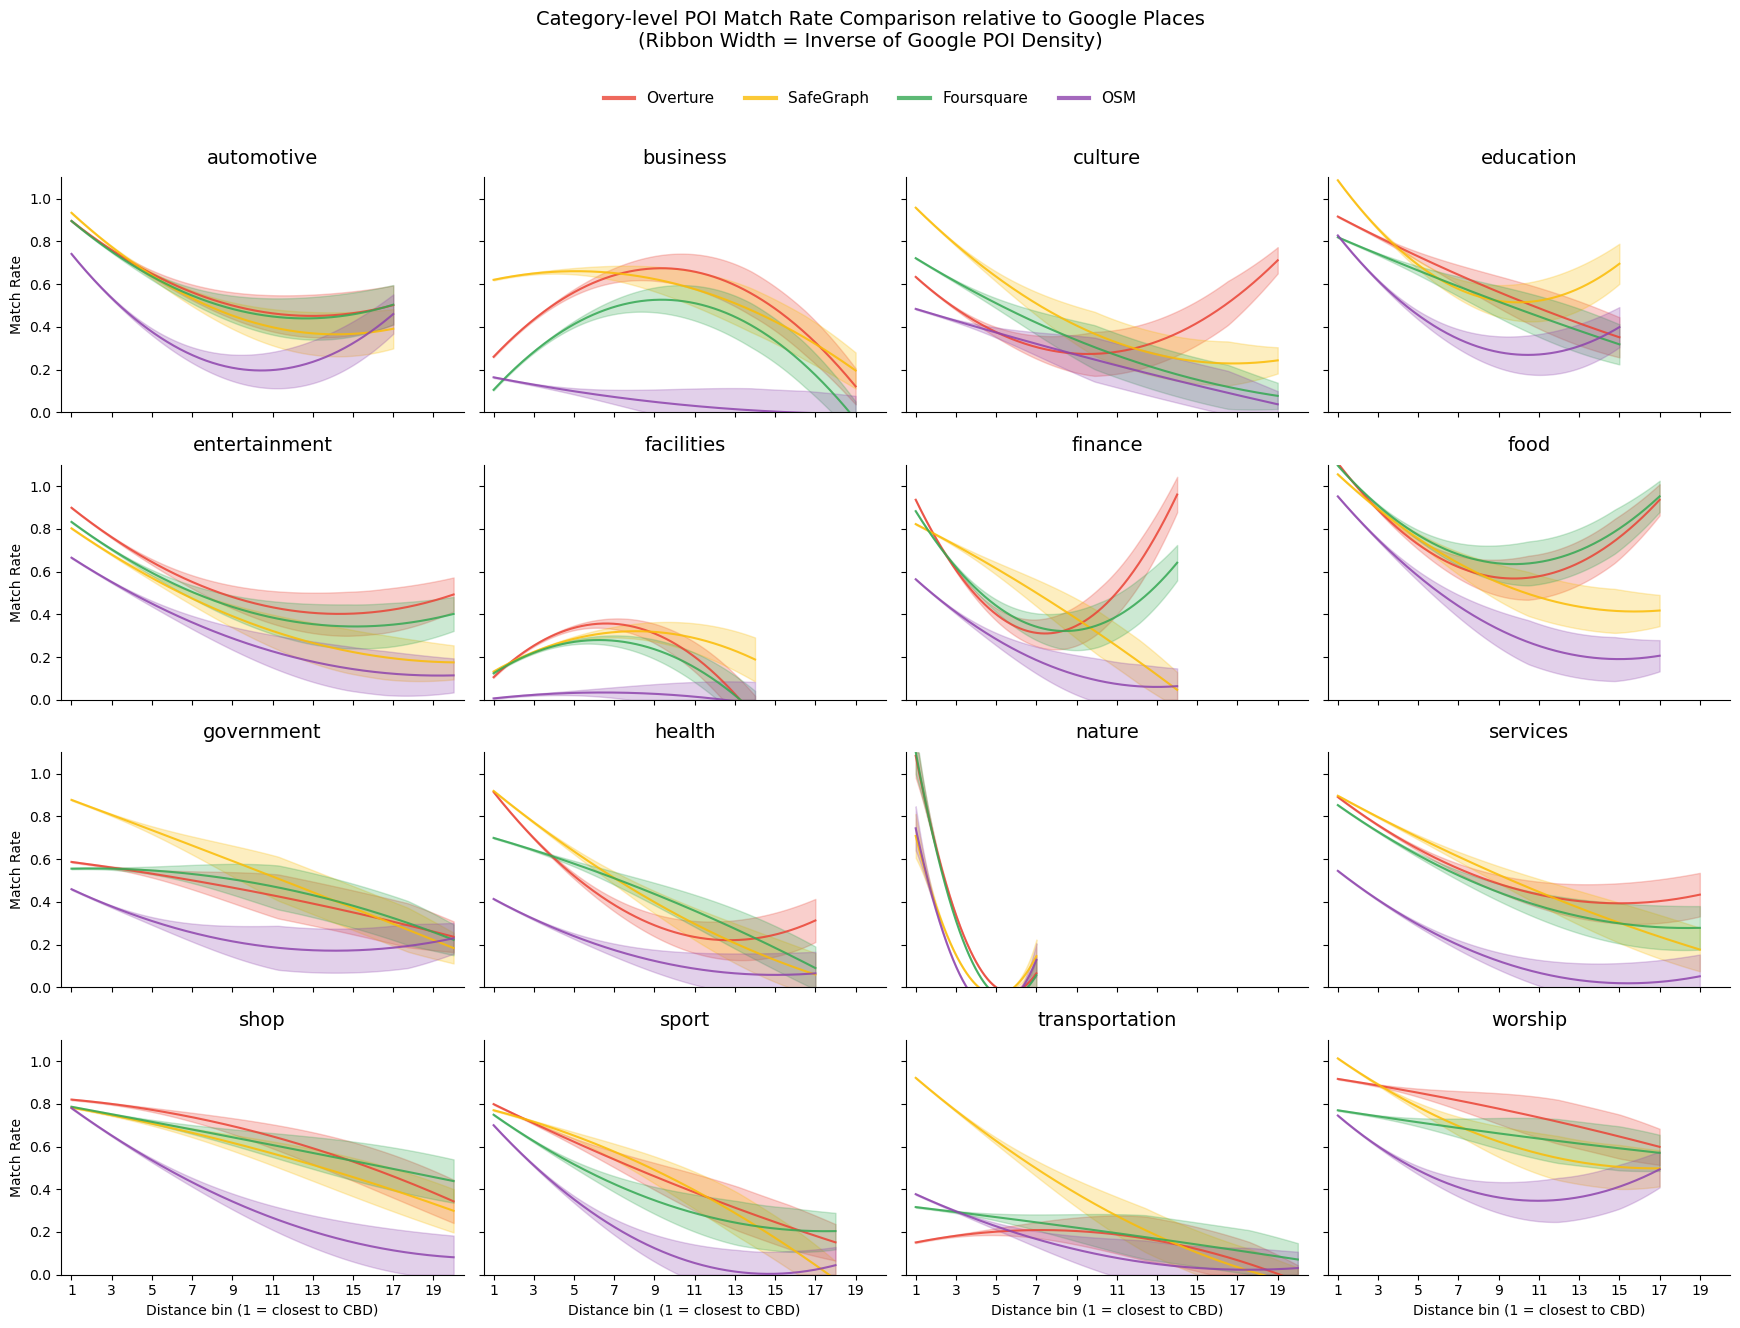

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_variable_width_missmate(
    df,
    c_cols=("match_c_ove", "match_c_sf", "match_c_fsq", "match_c_osm"),
    den_cols=("total_den_google", "total_den_google", "total_den_google", "total_den_google"),
    primary_cat_col="primary_cat",
    n_cols=4,
    title="Category-level POI Match Rate Comparison relative to Google Places\n(Ribbon Width = Inverse of Google POI Density)"
):
    colors_dict = {"ove": "#EA4335", "sf": "#FBBC05", "fsq": "#34A853", "osm": "#8E44AD"}
    display_labels = {"ove": "Overture", "sf": "SafeGraph", "fsq": "Foursquare", "osm": "OSM"}

    cats = sorted(df[primary_cat_col].unique())
    n_cats = len(cats)
    n_rows = int(np.ceil(n_cats / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols + 1.5, 3 * n_rows + 1.5),
        squeeze=False,
        sharex=True,
        sharey=True,
        facecolor='white'
    )

    for i, (ax, cat) in enumerate(zip(axes.flat, cats)):
        df_cat = df[df[primary_cat_col] == cat].sort_values("bin_id")
        x = df_cat["bin_id"].values

        for c_col, d_col in zip(c_cols, den_cols):
            src = c_col.split('_')[-1]
            color = colors_dict.get(src, "#333333")

            y = df_cat[c_col].values
            dens = df_cat[d_col].values

            # 过滤 NaN
            mask = ~(np.isnan(y) | np.isnan(dens))
            x_v, y_v, d_v = x[mask], y[mask], dens[mask]
            if len(x_v) < 4:
                continue

            # --- 多项式回归平滑 ---
            x_smooth = np.linspace(x_v.min(), x_v.max(), 300)
            deg = 2
            coef_y = np.polyfit(x_v, y_v, deg)
            coef_d = np.polyfit(x_v, d_v, deg)
            spl_y = np.polyval(coef_y, x_smooth)
            spl_d = np.clip(np.polyval(coef_d, x_smooth), 0, None)

            # --- per-line 归一化 + 幂次拉大对比 ---
            den_norm = (spl_d - spl_d.min()) / (spl_d.max() - spl_d.min() + 1e-9)
            ribbon_half = np.power(1 - den_norm, 3) * 0.10 + 0.003

            y_upper = np.clip(spl_y + ribbon_half, 0, 1.1)
            y_lower = np.clip(spl_y - ribbon_half, 0, 1.1)

            # 绘制 ribbon
            ax.fill_between(x_smooth, y_lower, y_upper,
                            color=color, alpha=0.25, zorder=2)
            # 绘制中心线
            ax.plot(x_smooth, spl_y, color=color, lw=1.5, alpha=0.85, zorder=3)

        ax.set_title(cat, fontsize=14, pad=10)
        ax.set_ylim(0, 1.1)
        ax.set_xlim(0.5, 20.5)
        ax.set_xticks(range(1, 21, 2))

        if i % n_cols == 0:
            ax.set_ylabel("Match Rate", fontsize=10)
        if i >= (n_rows - 1) * n_cols:
            ax.set_xlabel("Distance bin (1 = closest to CBD)", fontsize=10)

        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)

    for ax in axes.flat[n_cats:]:
        ax.axis("off")

    fig.suptitle(title, fontsize=14, y=0.98, va="top")

    legend_handles = [
        Line2D([0], [0], color=colors_dict[s], lw=3, alpha=0.8, label=display_labels[s])
        for s in ["ove", "sf", "fsq", "osm"]
    ]
    fig.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.93),
        frameon=False,
        ncol=4,
        fontsize=11
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

plot_variable_width_missmate(all_bins)

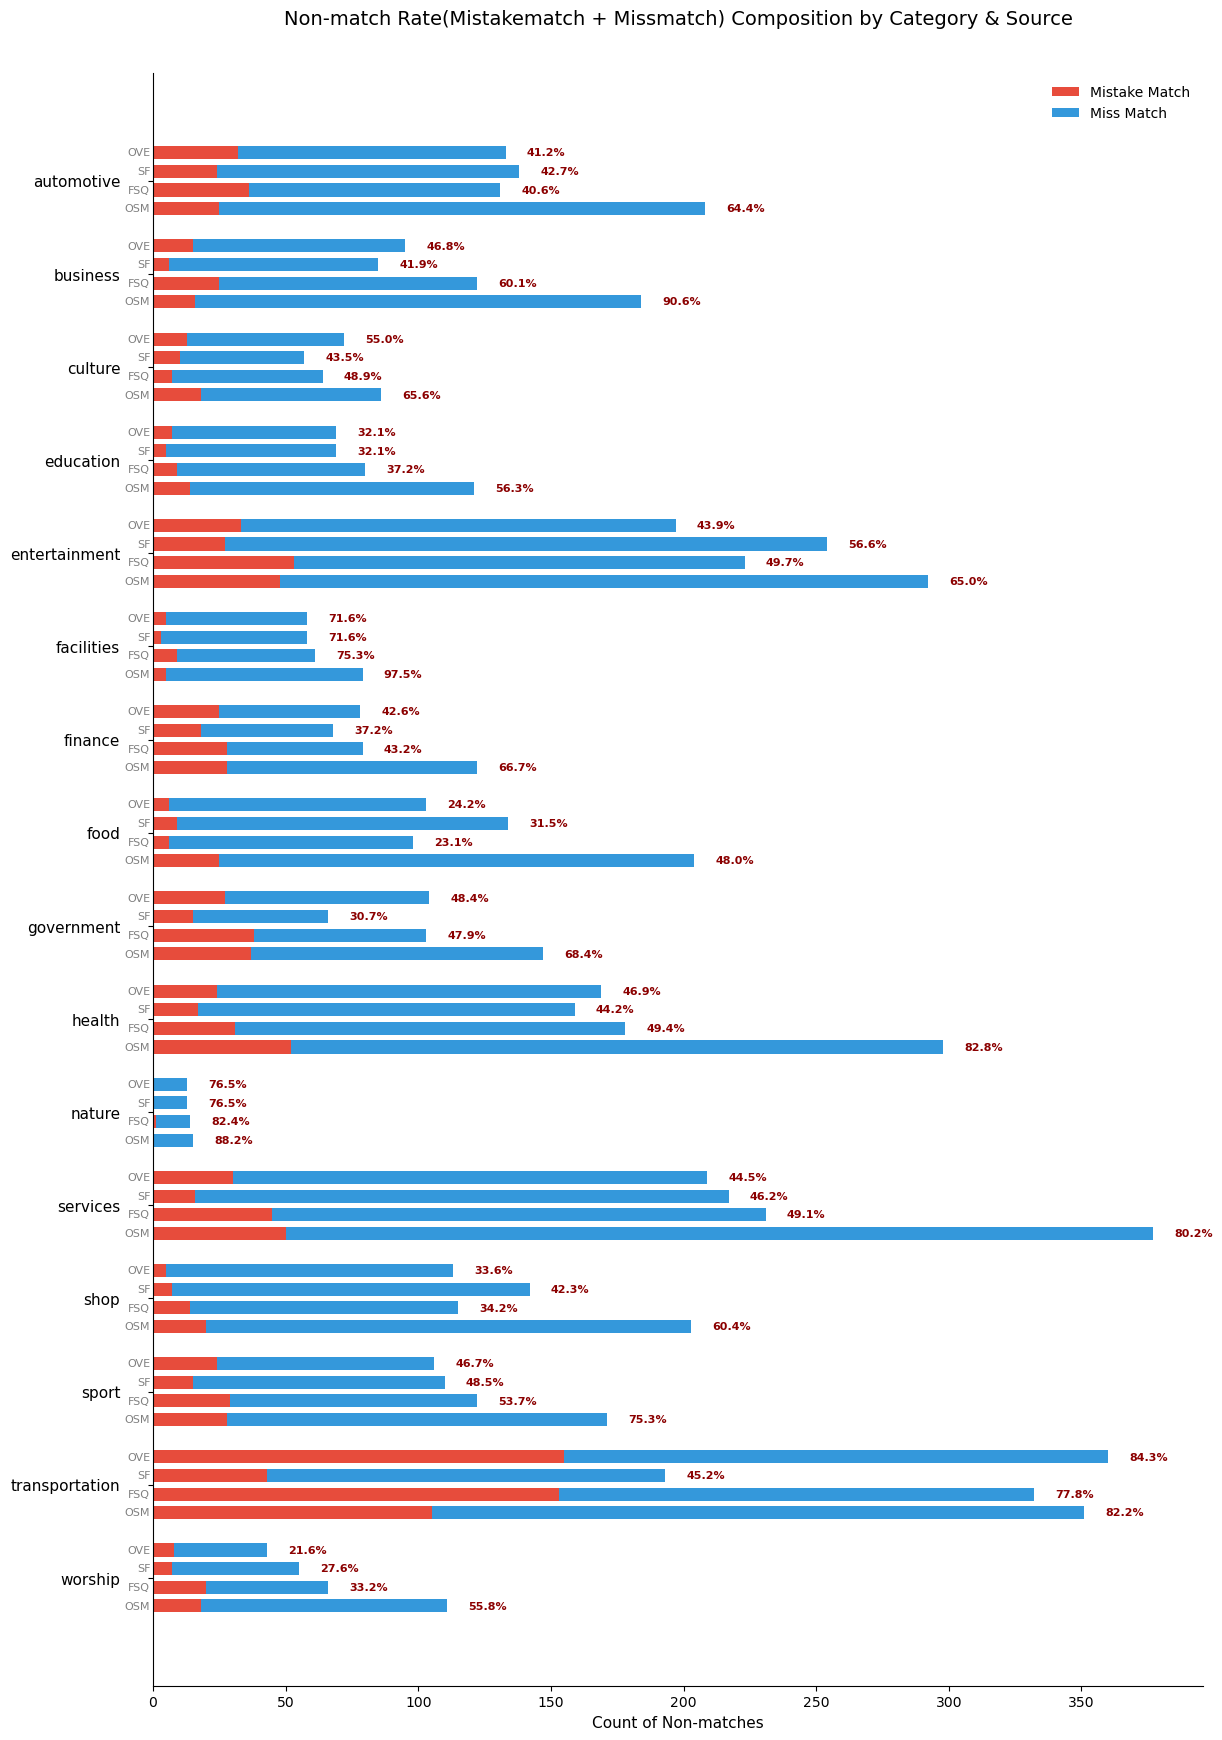

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

# 1. 数据处理函数 (保持不变)
def process_stats(df, source_name):
    temp = df.copy()
    temp['is_mistake'] = (temp["is_true_match"] == "0")
    temp['is_miss'] = temp["is_true_match"].isna()
    
    stats = temp.groupby("primary_cat").agg(
        n_mistake=('is_mistake', 'sum'),
        n_miss=('is_miss', 'sum'),
        total_count=('primary_cat', 'count')
    ).reset_index()
    
    stats['total_non_match'] = stats['n_mistake'] + stats['n_miss']
    stats['miss_rate'] = stats['total_non_match'] / stats['total_count']
    stats['source'] = source_name
    return stats

# 2. 汇总数据
dfs_input = {
    "OVE": bspo_gplc_ove,
    "SF": bspo_gplc_sf,
    "FSQ": bspo_gplc_fsq,
    "OSM": bspo_gplc_osm
}

all_stats_list = [process_stats(d, name) for name, d in dfs_input.items()]
df_combined = pd.concat(all_stats_list)

# 3. 筛选并排序 (按总非匹配数从大到小)
TOP_N = 20
top_cats = df_combined.groupby("primary_cat")['total_non_match'].sum().nlargest(TOP_N).index.tolist()
top_cats = sorted(top_cats, reverse=True) 

# 4. 绘图
n_cats = len(top_cats)
sources = ["OVE", "SF", "FSQ", "OSM"]
n_src = len(sources)
colors = {"Mistake": '#e74c3c', "Miss": '#3498db'}

fig, ax = plt.subplots(figsize=(14, n_cats * 1.2), facecolor='white')

y_base = np.arange(n_cats) * (n_src + 1) 

for i, cat in enumerate(top_cats):
    cat_data = df_combined[df_combined['primary_cat'] == cat]
    
    for j, src in enumerate(sources):
        row_y = y_base[i] + (n_src - 1 - j) 
        src_row = cat_data[cat_data['source'] == src]
        
        if not src_row.empty:
            mistake = src_row['n_mistake'].values[0]
            miss = src_row['n_miss'].values[0]
            rate = src_row['miss_rate'].values[0]
            total = src_row['total_non_match'].values[0]
            
            ax.barh(row_y, mistake, color=colors["Mistake"], height=0.7)
            ax.barh(row_y, miss, left=mistake, color=colors["Miss"], height=0.7)
            
            # 【优化】增加负向偏移 (-15)，确保 OVE/SF 等文字不与 Y 轴刻度重叠
            ax.text(-1, row_y, src, ha='right', va='center', fontsize=8, alpha=0.5)
            
            if total > 0:
                ax.text(total + 8, row_y, f'{rate:.1%}', va='center', ha='left', 
                        fontsize=8, color='darkred', fontweight='bold')

# 5. 【优化】样式修正
ax.set_yticks(y_base + (n_src-1)/2)
# 去掉 fontweight='bold'，还原为普通字体
ax.set_yticklabels(top_cats, fontsize=11)
ax.tick_params(axis='y', which='major', pad=20)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.set_xlabel("Count of Non-matches", fontsize=11)
ax.set_title("Non-match Rate(Mistakematch + Missmatch) Composition by Category & Source", fontsize=14, pad=35)

# 统一图例
legend_elements = [Patch(facecolor=colors["Mistake"], label='Mistake Match'),
                   Patch(facecolor=colors["Miss"], label='Miss Match')]
ax.legend(handles=legend_elements, loc='upper right',  frameon=False)

# 【优化】通过 subplots_adjust 明确给左侧留出空间 (left=0.2)
plt.subplots_adjust(left=0.2, right=0.95, top=0.92, bottom=0.08)

plt.show()